# Análise de Usuários através de Keystrokes

Nesse trabalho, busco explorar o quanto o modo como um usuário digita diz sobre ele. É possível dicerní-lo de outros apenas por seu padrão de digitação? Conseguimos agrupar usuários que digitam de forma parecida? O que mais é possível extrair de dados de telcas?

## Motivação

Qual a utilidade de ser se estudar padrões de digitação de um usuário?

Assumindo que cada usuário tem um padrão de digitação único, ou pelo menos razoavelmente único, é possível pensar em uma tarefa de identificação. Sites como o Coursera utilizam esses dados justamente para julgar se um aluno realmente está fazendo os deveres do curso. Logo quando um usuário se cadastra, ele deve digitar um parágrafo para que um perfil associado seja criado. Esse perfil é então comparado posteriormente aos textos (códigos ou respostas discursivas) escritos pelo aluno. Por ser utilizado por tanto tempo na plataforma, podemos suspeitar que esse tipo de dado é um bom indicativo de unicidade.

Outra aplicação possível é identificação de usuários fazendo login. Se um sistema for capaz de identificar o usuário pelo modo como digita, uma camada a mais de segurança pode ser criada. Afinal, não basta saber a senha da conta, é necessário digitar como o dono original digita. Dessa forma, fraudes por senhas vazadas, bancos de dados comprometidos, ou até mesmo senhas anotadas em _post-its_ no monitor podem ser evitadas.

Para o caso de uso da senha é interessante notar um detalhe que é o não envio da senha em _plain text_ ao servidor verificador. É extremamente comum - se crucial para uma base mínima de segurança - que a senha de um usuário não trafegue a rede em _plain text_. Isso porque é muito fácil um malfeitor capturar dados transientes em uma rede (principalmente pública). Dessa forma, se a senha não tiver nenhum mecanismo de proteção, a conta do usuário estará comprometida.

O que normalmente ocorre é o envio de um _hash_ da senha. O _hash_ nada mais é do que uma função que leva uma entrada a uma saída de forma simples, mas garante que a inversão (sabendo uma saída, encontrar a entrada correspondente) é uma tarefa árdua. Utilizando esse método, sites que permitem fazer login não precisam guardar as senhas de seus usuários, basta guardar os hashes das senhas. Afinal, como cada senha sempre produz o mesmo hash, é possível comparar hashes para saber se a senha está correta. Aplicando essa metodologia, mesmo que ocorra um vazamento de senhas ou uma senha seja fisgada em trânsito, o segredo está seguro. Apenas o hash foi comprometido e como dito acima, hashes são difíceis de reverter.

O que isso implica na utilização de dados de digitação para verificação do usuário? Imediatamente, significa que não se pode utilizar as teclas nem os tempos de digitação entre elas para tirar tais conclusões. Afinal, se isso fosse utilizado, todo o propósito de não enviar a senha em _plain text_ estará perdido. Soluções mais criativas terão que ser utilizadas, como veremos a frente.

## Dataset

Para começar a exploração desse tópico, escolhi um dataset famoso de dados de _keystrokes_. O dataset é conhecido como _CMU Keystroke Dynamics – Benchmark Data Set_.

### Contrução do dataset

Esse dataset foi montado com dados de 51 pessoas diferentes digitando a senha `.tie5Roanl` repetidas vezes. Ao todo foram 400 repetições por pessoa espaçadas em sessões distintas. Em cada sessão a pessoa digitava a senha 50 vezes, implicando num total de 8 sessões que foram feitas com pelo menos um dia de folga entre elas para capturar a variação de padrões de digitação ao longo de dias.

### Dados coletados

Resta, agora, sabermos que métricas foram efetivamente coletadas e armazenadas nesse dataset. Cada sessão de coleta captura três tipos de dados: `Hold`, `Down-Down`, `Up-Down`.

![Métricas coletadas](data_explanation.jpg)

- Hold: Mede o tempo que uma tecla foi pressionada (desde o momento que foi abaixada até quando é solta).
- Down-Down: Mede o tempo entre uma tecla ser abaixada e a próxima ser abaixada.
- Up-Down: Mede o tempo entre uma tecla ser solta e a próxima abaixada.

Dessa forma, como o texto digitado foi `.tie5Roanl`, cada entrada do dataset será composta dos seguintes atributos:

```
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i, ... , H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
```

O primeiro parâmetro indica qual participante digitou essa entrada do dataset. O atributo `sessionIndex` indica a qual sessão essa captura faz parte e `rep` qual a repetição dentro dessa sessão. A partir desse ponto começam as medidas de tempo. O primeiro campo, `H.period`, indica o tempo que a tecla de _ponto final_ ficou pressionada (_Hold period_). Em seguida, temos `DD.period.t` que indica o tempo entre a tecla de _ponto final_ ser pressionada para baixo e a tecla `t` ser pressionada para baixo (_Down-Down period t_). Analogamente, `UD.period.t` mostra o tempo entre soltar o _ponto final_ e pressionar a tecla `t`. As mesmas três métricas se repetem para as próximas teclas da senha. É importante notar que a tecla `Enter` foi pressionada ao final da digitação e é expressa no dataset por meio do termo _Return_.

## Análise inicial dos dados

Sabendo como o dataset foi construído, comecemos por tentar entender seus dados. Comecemos por uma redução de dimensionalidade para ser possível desenhar um plot 2D dos pontos. Com isso teremos alguma ideia de como os dados se comportam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

Comecemos por ler os dados do arquivo em que estão salvos e separá-los por linhas. Aqui também jogaremos o cabeçalho fora, visto que não será utilizado nas manipulações e já temos uma descrição dos dados acima.

In [2]:
# Lendo dados do arquivo
with open("DSL-StrongPasswordData.csv") as f:
    data = np.array([line.split(",") for line in f.read().strip().split("\n")[1:]])

Agora, separemos os identificadores de usuários dos dados propriamente ditos.

In [3]:
# Formatando os dados
np.random.seed(1234)
np.random.shuffle(data)
recordings, keystrokes = data[:,:3], data[:,3:].astype(float)
print(recordings[:2], "\n", keystrokes[:2])

[['s040' '5' '44']
 ['s036' '7' '35']] 
 [[ 0.1227  0.3441  0.2214  0.1071  0.1493  0.0422  0.106   0.3349  0.2289
   0.153   0.73    0.577   0.0731  0.5698  0.4967  0.0839  0.3472  0.2633
   0.1124  0.16    0.0476  0.1765  0.2884  0.1119  0.1097  0.3012  0.1915
   0.0823  0.2655  0.1832  0.1084]
 [ 0.0377  0.5097  0.472   0.0475  0.2709  0.2234  0.0409  0.2883  0.2474
   0.0457  0.4903  0.4446  0.042   0.4409  0.3989  0.0351  0.605   0.5699
   0.0285  0.2008  0.1723  0.0525  0.3788  0.3263  0.0327  0.4781  0.4454
   0.0393  0.4406  0.4013  0.0364]]


Para termos certeza de que tudo está coerente no dataset, verifiquemos a quantidade de colunas da matriz e comparemos com o tamanho do que foi digitado.

In [4]:
password = ".tie5Roanl\n" # Lembrando que o enter é pressionado ao final da senha
print("Número de teclas na digitação da senha: {}".format(len(password)))
print("Número de colunas na matriz do dataset: {}".format(keystrokes.shape[1]))

Número de teclas na digitação da senha: 11
Número de colunas na matriz do dataset: 31


Exatamente como o esperado. Afinal, temos três medições por tecla pressionada (exceto a última) e temos 11 teclas pressionadas. Como não há teclas após o `Enter`, essa tecla só terá a métrica de `Hold` medida. Isso totalizará em exatas **31 medições**, como imaginávamos.

Verifiquemos agora o número de usuários no dataset.

In [5]:
users = sorted(list(set(recordings[:,0])))
print("Identificadores de usuários: {}".format(users))
print("Quantidade de usuários únicos: {}".format(len(users)))

Identificadores de usuários: ['s002', 's003', 's004', 's005', 's007', 's008', 's010', 's011', 's012', 's013', 's015', 's016', 's017', 's018', 's019', 's020', 's021', 's022', 's024', 's025', 's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034', 's035', 's036', 's037', 's038', 's039', 's040', 's041', 's042', 's043', 's044', 's046', 's047', 's048', 's049', 's050', 's051', 's052', 's053', 's054', 's055', 's056', 's057']
Quantidade de usuários únicos: 51


Apliquemos a decomposição SVD nos dados como intermédio de redução de dimensionalidade para que possamos mostrar os pontos do dataset em um espaço 2D euclidiano.

In [6]:
partial = keystrokes[:2000]

In [7]:
partial

array([[ 0.1227,  0.3441,  0.2214, ...,  0.2655,  0.1832,  0.1084],
       [ 0.0377,  0.5097,  0.472 , ...,  0.4406,  0.4013,  0.0364],
       [ 0.0853,  0.1757,  0.0904, ...,  0.1929,  0.1121,  0.0829],
       ..., 
       [ 0.0776,  0.3103,  0.2327, ...,  0.2907,  0.1917,  0.0945],
       [ 0.0591,  0.265 ,  0.2059, ...,  0.5553,  0.4746,  0.0886],
       [ 0.0657,  0.409 ,  0.3433, ...,  0.3733,  0.2881,  0.072 ]])

In [8]:
decomp = np.linalg.svd(partial)

In [9]:
U, sigma, Vt = decomp
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(2000, 2000)
(31,)
(31, 31)


[  5.37860351e+01   1.45971181e+01   1.39542872e+01   1.13840973e+01
   9.56374289e+00   9.20264712e+00   7.71927016e+00   7.52113688e+00
   6.41529380e+00   5.77067003e+00   5.50869931e+00   1.58892232e+00
   1.37413431e+00   1.25452098e+00   1.12088379e+00   1.08756954e+00
   9.80826384e-01   8.76163838e-01   8.50212712e-01   8.28806611e-01
   7.73274781e-01   3.51964339e-14   1.44156497e-14   1.19870887e-14
   7.79112368e-15   7.74209255e-15   5.80840869e-15   4.44215664e-15
   4.44215664e-15   3.54364698e-15   2.97049823e-15]


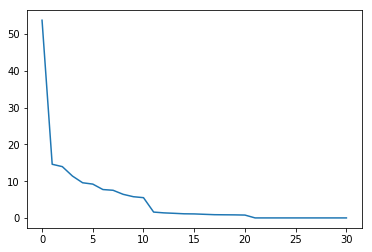

In [10]:
print(sigma)
plt.plot(sigma)
plt.show()

In [11]:
Sigma = np.zeros((2000, 31))
Sigma[0][0] = sigma[0]
Sigma[1][1] = sigma[1]
print(Sigma)

Vt_2D = np.zeros((Vt.shape[0],2))
Vt_2D[:,:2] = Vt[:,:2]
print(Vt_2D)

partial_2D = U.dot(Sigma.dot(Vt_2D))
print(partial_2D)

[[ 53.7860351    0.           0.         ...,   0.           0.           0.        ]
 [  0.          14.59711807   0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 ..., 
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   0.           0.           0.        ]]
[[ -6.75936637e-02  -2.49557191e-01]
 [ -1.83758381e-02   4.50418569e-01]
 [  1.78634943e-02   1.04421094e-01]
 [ -6.48506372e-02   4.12272012e-01]
 [  1.63725324e-01   2.09097054e-01]
 [ -1.31253972e-01   2.51447174e-02]
 [  7.42528957e-02   8.41307492e-02]
 [ -3.02612331e-02  -1.04679674e-01]
 [  5.76043880e-02   2.65105431e-02]
 [ -6.14543112e-02  -2.18016951e-02]
 [  5.57318797e-02   4.99800247e-02]
 [ -2.57013496e-01  -1.26424121e-01]
 [  3.85613053e-01   1.98459893e

In [15]:
colors = {
    "s002": "#0048BA",
    "s003": "#B0BF1A",
    "s004": "#7CB9E8",
    "s005": "#C9FFE5",
    "s007": "#B284BE",
    "s008": "#00308F",
    "s010": "#72A0C1",
    "s011": "#AF002A",
    "s012": "#84DE02",
    "s013": "#E32636",
    "s015": "#C46210",
    "s016": "#EFDECD",
    "s017": "#E52B50",
    "s018": "#9F2B68",
    "s019": "#F19CBB",
    "s020": "#AB274F",
    "s021": "#D3212D",
    "s022": "#3B7A57",
    "s024": "#FFBF00",
    "s025": "#FF7E00",
    "s026": "#3B3B6D",
    "s027": "#391802",
    "s028": "#804040",
    "s029": "#D3AF37",
    "s030": "#34B334",
    "s031": "#FF8B00",
    "s032": "#FF9899",
    "s033": "#431C53",
    "s034": "#B32134",
    "s035": "#FF033E",
    "s036": "#CFCFCF",
    "s037": "#551B8C",
    "s038": "#F2B400",
    "s039": "#9966CC",
    "s040": "#A4C639",
    "s041": "#F2F3F4",
    "s042": "#CD9575",
    "s043": "#665D1E",
    "s044": "#915C83",
    "s046": "#841B2D",
    "s047": "#FAEBD7",
    "s048": "#008000",
    "s049": "#66B447",
    "s050": "#8DB600",
    "s051": "#FBCEB1",
    "s052": "#00FFFF",
    "s053": "#7FFFD4",
    "s054": "#D0FF14",
    "s055": "#C0C0C0",
    "s056": "#4B5320",
    "s057": "#3B444B"
}

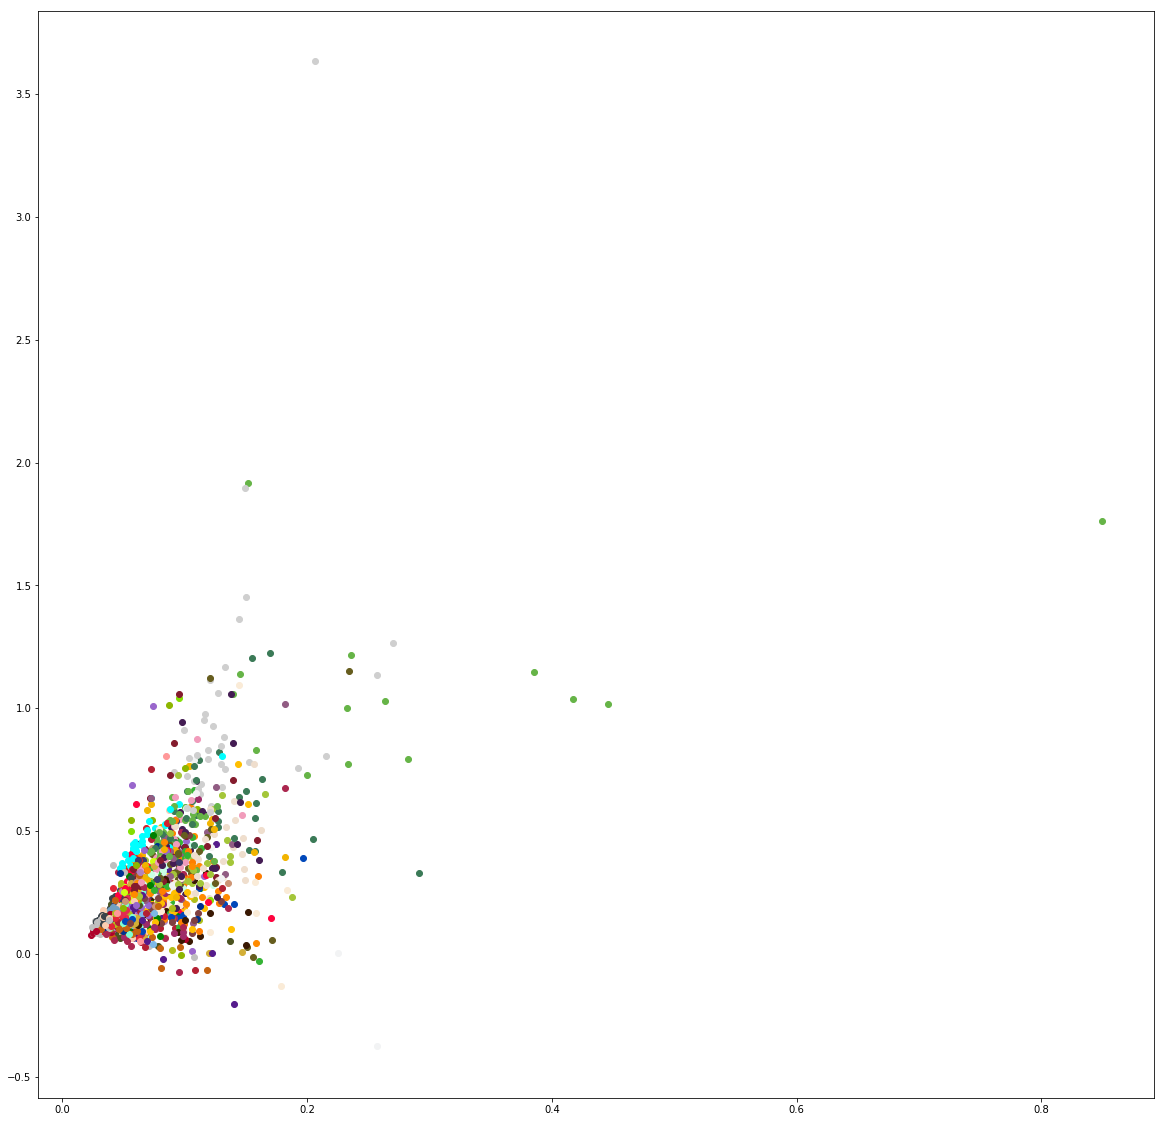

In [18]:
plt.figure(figsize=(20,20))
for i, point in enumerate(partial_2D):
    plt.scatter(point[0], point[1], c=colors[recordings[i][0]])
plt.show()

In [13]:
partial_2D

array([[ 0.10593932,  0.28981998],
       [ 0.10540816,  0.59793701],
       [ 0.04637591,  0.17384805],
       ..., 
       [ 0.07725431,  0.3062696 ],
       [ 0.06016892,  0.36243945],
       [ 0.08317183,  0.42905028]])